# 実際に回帰問題を解いてみる

## 回帰問題編

解説付きでコードを示しています．使い方としては

1. 上から順に読んで（重要），
2. セルを実行していってください．
3. 理解できない場合は，スタッフに質問を投げるなどしてください．
4. 理解が進んだら，自分のノートを作成し，ページにコードを真似して記述していってください．

In [21]:
# まずは必要そうなものをインポート scipy は要らないかも
import numpy as np
import matplotlib.pylab as plt

ここでは直線のモデル $y = a x + b$ を考えます．

データは，直線モデルから，ノイズが加えられて観測したものと仮定し，人工的に生成します．
要は，機械学習が出すべき答えを知っている状態で，データを適用しどのような解が得られるのかを実験することが目的となります．

詳細はコードに書いていますが，データを作成する場合は，直線モデルを具体的に与え(a = 1.2, b=0.5 などとして)，
ノイズの重畳過程も記載することが必要です．
ここではノイズの重畳は加法的ガウスノイズが重畳されるとし，ノイズの標準偏差は sgm = 0.2 としています．

In [22]:
# ここらへんのパラメータを変えて遊んでみてください

N = 50  #サンプル点の個数
a = 1.2  #モデル直線の傾き
b = 0.5  #モデル直線の切片
sgm = 0.2  # ノイズの標準偏差

x = np.random.rand(N)    # [0, 1) の区間に N 個の乱数発生
ytrue = a * x + b

y = ytrue  + sgm * np.random.randn(N)  # 真値にノイズを乗せて観測データを作る

### これで下準備完了

一応，解説を入れておくと

* `x`: データのx座標（乱数で生成） 
* `ytrue`: a x + b 上の値 
* `y`: `ytrue` にガウスノイズを載せたもの 

です．
なので，(x, y) にデータが入っていると思いましょうという話です．
そこで，これらの点のプロットと真の直線の関係を見てみることにします．

(0.4, 1.8)

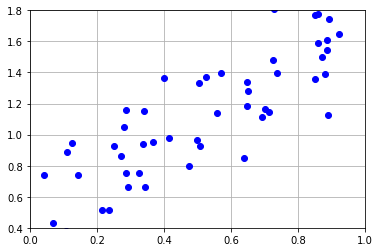

In [23]:
# 散布図の描画
plt.figure()
plt.plot(x, y, 'bo', label='data')
plt.grid()
plt.xlim(0, 1)
plt.ylim(0.4, 1.8)

このような青点の散布図が与えられたときに

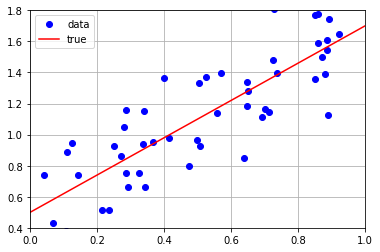

In [24]:
# 真の関係を描画
plt.figure()
plt.plot(x, y, 'bo', label='data')
plt.grid()
plt.xlim(0, 1)
plt.ylim(0.4, 1.8)
xx = np.linspace(0, 1, 128)
yy = a * xx + b
plt.plot(xx, yy, 'r-', label='true')
plt.legend()

上図のような赤線を得ることができるのか？というのが問いかけになります．
少しかっこいい言葉遣いをすれば

### 問い: データ点（青い点）のみから，もとになる直線（赤直線）を推定することは可能か？

になります．これには解法としていくつか考えられますが，ここでは以下のような機械学習と呼ばれる手法に頼ることとします．

データの点群を $\{(x_n, y_n)\}$ とし， 推定モデルを $f(x; w) = w_1 x + w_0$ とおいて， $w_0$ と $w_1$ を推定することを考えます．
この問題は *最小二乗法* の問題で，　以下の関数（ロス関数と呼ばれる）
$$
    J(w) = \frac{1}{N} \sum_n (y_n - f(x_n))^2
$$
を，最小化する $w$ を求めます．

### 要はモデル $f(x_n)$ と，　観測点 $y_n$ の差（残差）が小さくなる $w$ を求める．

ことがやりたいことになります．

この問題は，正規方程式
$$
    \left(\begin{array}{rr} N & \sum x_n \\ \sum x_n  & \sum x_n^2 \end{array}\right) 
    \left(\begin{array}{r} w_0 \\ w_1 \end{array}\right)
    =
     \left(\begin{array}{r} \sum y_n \\ \sum x_n y_n \end{array}\right)
$$
を解けばよい（導出が知りたければ質問すること）ことになります．
解は下記のとおりです．
$$
    \left(\begin{array}{r} w_0 \\ w_1 \end{array}\right)
    =
    \frac{1}{N \sum x_n^2 - (\sum x_n)^2}
    \left(\begin{array}{rr} \sum x_n^2  & - \sum x_n \\ - \sum x_n  & N\end{array}\right)
     \left(\begin{array}{r} \sum y_n \\ \sum x_n y_n \end{array}\right)
$$

In [25]:
# 最小二乗法から解をもとめよ

#とりあえず統計量を計算しておく（上式の和記号が付いたやつ）
xsum = x.sum()
x2sum = (x**2).sum()
ysum = y.sum()
xysum = x @ y

# 2x2 の逆行列は手計算で解ける
det = N * x2sum - (xsum)**2
w0 = (x2sum * ysum - xsum * xysum) / det
w1 = (-xsum * ysum + N * xysum) / det

print("Estimate w1, w0 = (%.3f, %.3f)" % (w1, w0))
print("True      a,  b = (%.3f, %.3f)" % (a, b))

Estimate w1, w0 = (1.193, 0.499)
True      a,  b = (1.200, 0.500)


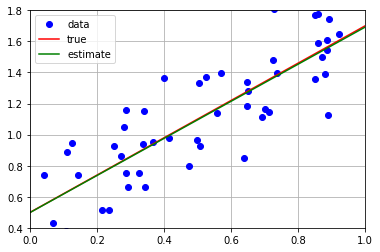

In [26]:
# 得られた直線が正しそうかプロット してみよう

plt.plot(x, y, 'bo', label='data')
plt.grid()
plt.xlim(0, 1)
plt.ylim(0.4, 1.8)

xx = np.linspace(0, 1, 128)
yy = a * xx + b
plt.plot(xx, yy, 'r-', label='true')
yy = w1 * xx + w0
plt.plot(xx, yy, 'g-', label='estimate')
plt.legend() # 凡例を描画

緑のラインが推定で，赤のラインが真値．

ついでに，残差とロス関数値も評価しておこう．　残差は モデル $f(x) = w_1 x + w_0$ が吐き出す予測値と $y$ の差の総和

In [27]:
# 残差を表示せよ

residual = np.sum((y - (w1 * x + w0))**2)
print( "Residual: %.3f" % (residual))
print( "Mean squared error %.3f" % (residual/N))   #1点あたりのズレ（平均二乗誤差）

Residual: 2.233
Mean squared error 0.045


全体の残渣がおおよそ 2.5 なので，1点あたりのズレは 0.052 となり

### うんだいたい良さげ

ということがわかります．

でも，正規方程式とか面倒です．．．で，この演習では python のパッケージを使った機械学習手法を習得しましょうという話になります．
紹介コードとしては，以下の２種を提供します．

1. scikit-learn を使う
2. Keras + Tensor 使う

このレベルの問題であれば１を使うのが楽ですが，後半の画像認識では，選択肢２がメインになるので，一応両方とも解法を記載しておきます．
なお，モデルは一緒でも 1 は，上述の行列を用いて解きますが，2 は勾配法を用いて解きますので，解へのアプローチが異なります．

## Scikit learn (sklearn) を使った解答

scikit-learn は機械学習のパッケージを万人がなるべく使いやすいようにという目的で作られたパッケージです．
このパッケージを用いた場合，やらなければいけないことは，

1.  適切なモデルの `import`
2. モデルのパラメータを適合させる `fit`

になります．この場合モデルとしては線形モデルを導入すればよいので，`linear_model` をいんぽーとします．
また，ロス関数は二乗誤差の形になるので `mean_squared_error` (平均二乗誤差）を距離尺度としてインポートします．

そのうえで，線形回帰モデル（`LinearRegression`）を用いれば，用途としては十分となります．
このような形でモデルを構築して，あとは細かい計算（上の正規方程式みたいなもの）はお任せで，モデルの `fit` メソッドを呼び出すことで適合させることができます．

1点注意しなければならないのは，`LinearRegression` オブジェクトは，データが行方向に並んでいることを仮定しているので `numpy` 配列を
`reshape` メソッドを使って変形してやる必要があります．（ここらへんはパッケージの流儀次第なので臨機応変に）

In [28]:
# sklearn を使った解答

from sklearn import linear_model   # 線形モデル導入
from sklearn.metrics import mean_squared_error  # 平均二乗誤差

# モデルは，回帰(regression) なので regr というオブジェクトとして扱う
regr = linear_model.LinearRegression()

#線形回帰モデル(Linear Regression()) が期待しているデータ形式は，各行にデータが入っているものなので reshape して渡す
regr.fit(x.reshape(N, 1), y.reshape(N, 1))

LinearRegression()

フィットさせることに成功した場合，なにもえらーは吐き出しません．
モデルを定義して, モデル内の fit() 関数を呼び出すだけでOKですが，知りたいのはモデルのパラメータなどです．
fit したあとは， モデル内の coef_ と intercept_ を見ればそこに解が入っています．

In [29]:
print("w0, w1 = (%.3f, %.3f)" % (regr.coef_, regr.intercept_))

w0, w1 = (1.193, 0.499)


OK,あってるぽい

さらに詳しい使い方を知りたければ， scikit-learn の web ページを読むと良いです（サンプルコードもいっぱいあります，英語だけど）

## Keras + TensorFlow を用いた解法

TensorFlow は，　Google が開発した深層学習要の枠組み（フレームワーク）です．
これだけでも使えるけど，ややマニアックな嫌いがあるので， それを噛み砕いたインターフェースが Keras だと
おもってもらってよいです

深層学習用のパッケージなので，普通は，
### こんな単純な回帰問題には *使いません* ．
が，使えないわけではありません．また，後半との連結をよくするために雰囲気で書いています．
（まじめに線形回帰するだけならscikit-learnのほうがうまく動きます）

Tensorflow + Keras でも

1. 必要なオブジェクトのインポート
2. モデルの構築
3. fit

という手順の流れは同等です．

どういうモデルをたてるかというと，2入力1出力のモデルで出力を線形関数とするだけです．

また，Keras + TensorFlow では **勾配法** という手法を用いて解へアプローチします．
scikit-learn や，正規方程式を解くみたいに問題解法をしているわけではありません．

平たく言えば，現在与えられている $a, b$ の組をもとに，目的関数が小さくなる方向を探して，
その方向に動いていくような手段です．
なので答えは微妙に違うことになります．

In [30]:
# Keras を用いて実現する
# インポートは，モデル構築のための枠組み
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation

回帰モデルは　$f(x; w) = w_1 x + w_0$ となり，パラメータは $w_1$ と $w_0$ な形で表されます．
これを計算グラフと呼ばれる表現（ニューラルネットワーク表現）であらわすと，入力 $x$ に対して
重み $w_1$ をかけ，バイアスとして $w_0$ を足したものを出力とするユニットを造ればよいということになります．

モデルを構築するための枠組みとしては，入力を変換して別形式にする `Sequential` モデルを使います．
この `Sequential` モデルの上に，入力が一つでバイアスありのモデルを `add` することでモデルを構築します．
畳み込みのような層を仮定しないのであれば， `Dense` と呼ばれるセルが並んだモデルを選ぶと良いです．
`Dense` モデルは入力の線形和を計算してくれます．具体的には，素子数と入力の形状を与えることで作成します．
`Dense(素子数, input_shape=入力形状)` のような形になります．
この場合は一つの素子しかなく，入力も x が1入力で，あとはバイアスに対応する項を考えるだけでよいので
`Dense(1, input_shape=(1,), use_bias=True)` のように形成すれば良いです．


さらにこのモデルにたいして，どのようなロス関数を用いて最適化を行うかを `model.compile()` を用いて指定します．

In [37]:
model = Sequential()   # 階層型のモデルを選択
model.add(Dense(1, input_shape=(1,), use_bias=True)) # 素子が一個の階層モデル

model.summary() # モデルの概要をアウトプット (確認は重要)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [45]:
#最適化手法を指定
model.compile(loss='mean_squared_error',  optimizer='adam') 

モデルができたら，あとは `fit` するという手続きを踏むだけです．

In [46]:
# 学習によるパラメータフィット
#hist = model.fit(x, y, epochs=５１２, batch_size=50, verbose=1)
hist = model.fit(x, y, epochs=1024, batch_size=50, verbose=1)

Epoch 1/1024
1/1 [==============================] - 0s 292ms/step - loss: 0.0453
Epoch 2/1024
1/1 [==============================] - 0s 9ms/step - loss: 0.0453
Epoch 3/1024
1/1 [==============================] - 0s 6ms/step - loss: 0.0452
Epoch 4/1024
1/1 [==============================] - 0s 7ms/step - loss: 0.0452
Epoch 5/1024
1/1 [==============================] - 0s 9ms/step - loss: 0.0452
Epoch 6/1024
1/1 [==============================] - 0s 7ms/step - loss: 0.0452
Epoch 7/1024
1/1 [==============================] - 0s 7ms/step - loss: 0.0452
Epoch 8/1024
1/1 [==============================] - 0s 14ms/step - loss: 0.0452
Epoch 9/1024
1/1 [==============================] - 0s 12ms/step - loss: 0.0452
Epoch 10/1024
1/1 [==============================] - 0s 11ms/step - loss: 0.0452
Epoch 11/1024
1/1 [==============================] - 0s 11ms/step - loss: 0.0451
Epoch 12/1024
1/1 [==============================] - 0s 14ms/step - loss: 0.0451
Epoch 13/1024
1/1 [=======================

うまくロス関数が小さくなっているかを確認する．
ロス関数の学習時の値は `fit` が返してくるオブジェクトの `history['loss']` という要素に入っているのでそれを表示させてみる．

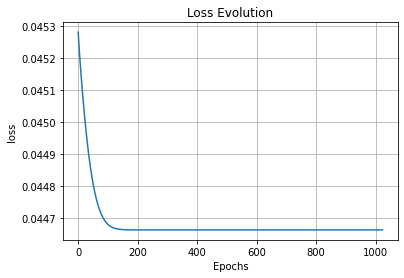

In [47]:
# ロスの値が学習によってどう変わっていくのかを表示してみる

plt.plot(hist.history['loss'])
#plt.semilogy(hist.history['loss']) #対数スケールの方が収束したかは判断しやすい
plt.title('Loss Evolution')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.grid()

かなり頑張ってるが，収束しているかは微妙．

まぁ，できたと思って，とりあえずパラメータを取り出して確認してみる

In [48]:
w1, w0 = model.get_weights()
print( "w0, w1 = (%.3f, %.3f)" % (w0, w1))

w0, w1 = (0.499, 1.193)


推定直線とデータ，真の直線を重ねて見る

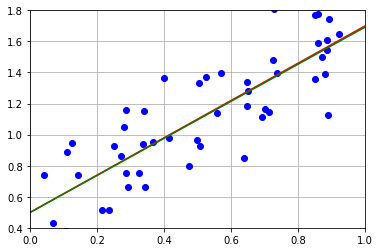

In [49]:
#w0 と w1 は，　np.array なので，使いやすいように float 型へ変換しておく
w0 = float(w0)
w1 = float(w1)

# あとはプロット
plt.plot(x, y, 'bo')
plt.grid()
plt.xlim(0, 1)
plt.ylim(0.4, 1.8)

xx = np.linspace(0, 1, 128)
yy = a * xx + b
plt.plot(xx, yy, 'r-')
yy = w1 * xx + w0
plt.plot(xx, yy, 'g-')

多分，前述の解とは微妙にずれているが，そんなに致命的ではないのを確認してください.
逆説的に言えば，機械学習による推定とは，そのくらいの誤差が含まれるので，設計するときのそれを意識する必要があります．